# Initial State Estimation Using NOE-5 Ephemeris
Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Objectives
This example illustrates how to optimize the **initial conditions** of a fixed dynamical model to **better match the available ephemeris of a celestial body**, using them as **"artificial" observations**. By adjusting the initial state, the goal is to minimize the discrepancy between the model’s predicted orbit and the ephemeris provided orbit over time. 

We will showcase how we can **enhance the accuracy of predicted orbits of the Galilean moons** based on the most current ephemerides (**NOE-5**) published by [Institut de mécanique céleste et de calcul des éphémérides](https://www.imcce.fr/institut/presentation/) (IMCEE).

In particular, we will:

1) **simulate observations** based on the ephemerides of the Galilean moons;
2) **estimate an improved initial state** for all four moons, such that
   the propagated orbit **minimizes the observations (ephemeris) residuals**
3) inspecting the (correct) representation and stability of the **Laplace resonance** between the inner three moons (Io, Europa, and Ganymede).

## Import Statements
Typically - in the most pythonic way - all required modules are imported at the very beginning.

Some standard modules are first loaded: `numpy` and `matplotlib.pyplot`. Within this example, while no particular new functionality of `tudatpy` will be introduced, we will nevertheless explore the already known parts of the `estimation` module in more depth and how it can be applied to **intricate problems**.

In [1]:
# General imports
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

# tudatpy imports
from tudatpy import util
from tudatpy import constants
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.astro import time_conversion, element_conversion
from tudatpy.numerical_simulation import environment_setup
from tudatpy.numerical_simulation import propagation_setup
from tudatpy.numerical_simulation import estimation, estimation_setup
from tudatpy.astro.time_conversion import DateTime

## Orbital Simulation
Entirely independent of the upcoming estimation-process, we first have to:

* define the **general settings of the simulation**
* create the **environment**
* define all relevant **propagation settings**

### Simulation Settings
Besides importing tudat's standard kernels - which handily already include a version of the **NOE-5 ephemeris**, for more details see also the `load_standard_kernels` function - in terms of time-wise settings we have (arbitrarily) chosen to make use of the nominal duration of ESA's JUICE mission as scope of our simulation. Nonetheless, note that any other reasonably long time-span would have been equally sufficient.

In [2]:
# Load spice kernels
spice.load_standard_kernels()

# Define temporal scope of the simulation - equal to the time JUICE will spend in orbit around Jupiter
simulation_start_epoch = DateTime(2031, 7,  2).epoch()
simulation_end_epoch   = DateTime(2035, 4, 20).epoch()

### Create the Environment
For the problem at hand, the **environment** consists of the Jovian system with its four largest moons - Io, Europa, Ganymede, and Callisto - as well as Saturn and the Sun which will be relevant when creating some **perturbing accelerations** afterwards. 

While slightly altering the standard settings of the moons, such that their rotation around their own main axis resembles a synchronous rotation, we will also apply a tabulated ephemeris based on every current (standard) ephemeris to the moons' settings. While, at first glance, this does not add any value to the simulation, this step is crucial in order to later be able to simulate the moons states purely based on their ephemerides without having to propagate their states.

In [3]:
# Create default body settings for selected celestial bodies
jovian_moons_to_create = ['Io', 'Europa', 'Ganymede', 'Callisto']
planets_to_create = ['Jupiter', 'Saturn']
stars_to_create = ['Sun']
bodies_to_create = np.concatenate((jovian_moons_to_create, planets_to_create, stars_to_create))

# Create default body settings for bodies_to_create, with 'Jupiter'/'J2000'
# as global frame origin and orientation.
global_frame_origin = 'Jupiter'
global_frame_orientation = 'ECLIPJ2000'
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

### Ephemeris Settings Moons ###
for moon in jovian_moons_to_create:
    # Apply tabulated ephemeris settings
    body_settings.get(moon).ephemeris_settings = environment_setup.ephemeris.tabulated_from_existing(
    body_settings.get(moon).ephemeris_settings,
    simulation_start_epoch,
    simulation_end_epoch,
    time_step=5.0 * 60.0)

### Rotational Models ###
# Define overall parameters describing the synchronous rotation model
central_body_name = "Jupiter"
original_frame = "ECLIPJ2000"
target_frames = ['IAU_Io', 'IAU_Europa', 'IAU_Ganymede', 'IAU_Callisto']
# Define satellite specific parameters and change rotation model settings
for moon_idx, moon in enumerate(jovian_moons_to_create):
    body_settings.get(moon).rotation_model_settings = environment_setup.rotation_model.synchronous(
        central_body_name, original_frame, target_frames[moon_idx])

# Create system of selected bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

### Create Propagator Settings
Trivially, in order to **estimate 'better' initial states** for the Galilean moons (as for to the objectives discussed above), we have to include all four of them in our propagation. Acceleration-wise, they are moreover modelled in the same fashion: 

* mutual spherical harmonic acceleration due to Jupiter,
* tidal dissipation on both the moons and the primary,
* mutual spherical harmonic acceleration due to the remaining three moons,
* and point mass gravity attraction by both Saturn and the Sun.

The **initial states** of the moons are taken from the **NOE-5 ephemeris** and will later also serve as **a-priori information and input to the estimator**. We will use a **Dormand-Prince 8th order integrator (RKDP8)** with a fixed step-size of **30 minutes**. Note that, while this example saves the Kepler elements of all four moons as dependent variables, this is not strictly necessary for the estimation, but purely serves as means of **better post-processing visualization** of the results.

In [4]:
# Define bodies that are propagated, and their central bodies of propagation
bodies_to_propagate = ['Io', 'Europa', 'Ganymede', 'Callisto']
central_bodies = ['Jupiter', 'Jupiter', 'Jupiter', 'Jupiter']

### Acceleration Settings ###
# Dirkx et al. (2016) - restricted to second degree
love_number_moons = 0.3
dissipation_parameter_moons = 0.015
q_moons = love_number_moons / dissipation_parameter_moons
# Lari (2018)
mean_motion_io = 203.49 * (math.pi / 180) * 1 / constants.JULIAN_DAY
mean_motion_europa = 101.37 * (math.pi / 180) * 1 / constants.JULIAN_DAY
mean_motion_ganymede = 50.32 * (math.pi / 180) * 1 / constants.JULIAN_DAY
mean_motion_callisto = 21.57 * (math.pi / 180) * 1 / constants.JULIAN_DAY

# Dirkx et al. (2016) - restricted to second degree
love_number_jupiter = 0.38
dissipation_parameter_jupiter= 1.1E-5
q_jupiter = love_number_jupiter / dissipation_parameter_jupiter

# Lainey et al. (2009)
tidal_frequency_io = 23.3 # rad.day-1
spin_frequency_jupiter = math.pi/tidal_frequency_io + mean_motion_io

# Calculate all required time lags associated with the individual tides
time_lag_io = 1 / mean_motion_io * np.arctan(1 / q_moons)
time_lag_jupiter_io = 1/(spin_frequency_jupiter - mean_motion_io) * np.arctan(1 / q_jupiter)
time_lag_europa = 1 / mean_motion_europa * np.arctan(1 / q_moons)
time_lag_jupiter_europa = 1 / (spin_frequency_jupiter - mean_motion_europa) * np.arctan(1 / q_jupiter)
time_lag_ganymede = 1 / mean_motion_ganymede * np.arctan(1 / q_moons)
time_lag_jupiter_ganymede = 1 / (spin_frequency_jupiter - mean_motion_ganymede) * np.arctan(1 / q_jupiter)
time_lag_callisto = 1 / mean_motion_callisto * np.arctan(1 / q_moons)
time_lag_jupiter_callisto = 1 / (spin_frequency_jupiter - mean_motion_callisto) * np.arctan(1 / q_jupiter)

time_lag_dict = {'Io': (time_lag_io, time_lag_jupiter_io),
                 'Europa': (time_lag_europa, time_lag_jupiter_europa),
                 'Ganymede': (time_lag_ganymede, time_lag_jupiter_ganymede),
                 'Callisto': (time_lag_callisto, time_lag_jupiter_callisto)}

acceleration_settings_moons = dict()

for idx, moon in enumerate(bodies_to_propagate):
    other_moons = np.delete(np.array(bodies_to_propagate), idx)
    acceleration_settings_moon = {
        'Jupiter': [propagation_setup.acceleration.mutual_spherical_harmonic_gravity(8, 0, 2, 2),
                 propagation_setup.acceleration.direct_tidal_dissipation_acceleration(love_number_moons,
                                                                                      time_lag_dict[moon][0],
                                                                                      True, False),
                 propagation_setup.acceleration.direct_tidal_dissipation_acceleration(love_number_jupiter,
                                                                                      time_lag_dict[moon][1],
                                                                                      True, True)],
        other_moons[0]: [propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
        other_moons[1]: [propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
        other_moons[2]: [propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
        'Sun': [propagation_setup.acceleration.point_mass_gravity()],
        'Saturn': [propagation_setup.acceleration.point_mass_gravity()]
    }
    acceleration_settings_moons[moon] = acceleration_settings_moon

acceleration_settings = acceleration_settings_moons
# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies)

# Define initial state
initial_states = list()
for body in bodies_to_propagate:
    initial_states.append(spice.get_body_cartesian_state_at_epoch(
        target_body_name=body,
        observer_body_name='Jupiter',
        reference_frame_name='ECLIPJ2000',
        aberration_corrections='none',
        ephemeris_time=simulation_start_epoch))
initial_states = np.concatenate(initial_states)

### Integrator Settings ###
# Use fixed step-size integrator (RKDP8) with fixed time-step of 30 minutes
# Create integrator settings
time_step_sec = 30.0 * 60.0
integrator_settings = propagation_setup.integrator. \
    runge_kutta_fixed_step_size(initial_time_step=time_step_sec,
                                coefficient_set=propagation_setup.integrator.CoefficientSets.rkdp_87)

### Termination Settings ###
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Define Keplerian elements of the Galilean moons as dependent variables
dependent_variables_to_save = [propagation_setup.dependent_variable.keplerian_state('Io', 'Jupiter'),
                               propagation_setup.dependent_variable.keplerian_state('Europa', 'Jupiter'),
                               propagation_setup.dependent_variable.keplerian_state('Ganymede', 'Jupiter'),
                               propagation_setup.dependent_variable.keplerian_state('Callisto', 'Jupiter')]

### Propagator Settings ###
propagator_settings = propagation_setup.propagator.translational(
                  central_bodies=central_bodies,
                  acceleration_models=acceleration_models,
                  bodies_to_integrate=bodies_to_propagate,
                  initial_states=initial_states,
                  initial_time=simulation_start_epoch,
                  integrator_settings=integrator_settings,
                  termination_settings=termination_condition,
                  output_variables=dependent_variables_to_save)

## Orbital Estimation
Having defined all settings required for the simulation of the moons' orbits, the orbital estimation can finally be discussed - we will have to create the required **link ends** for the Galilean moons, define the observation model and simulation settings, simulate the states of the moons based on their associated ephemerides, define the estimable parameters, and finally perform the estimation itself.

### Create Link Ends for the Moons
Since we will be using the [cartesian_position](https://py.api.tudat.space/en/latest/observation.html#tudatpy.numerical_simulation.estimation_setup.observation.cartesian_position) type of observable to simulate the ephemeris-states of the moons, we will have to define the link-ends for all four moons to be of the `observed_body` type. Finally, we will also have to create the complete set of link definitions for each moon individually.

In [5]:
link_ends_io = dict()
link_ends_io[estimation_setup.observation.observed_body] = estimation_setup.observation.body_origin_link_end_id('Io')
link_definition_io = estimation_setup.observation.LinkDefinition(link_ends_io)

link_ends_europa = dict()
link_ends_europa[estimation_setup.observation.observed_body] = estimation_setup.observation.body_origin_link_end_id('Europa')
link_definition_europa = estimation_setup.observation.LinkDefinition(link_ends_europa)

link_ends_ganymede = dict()
link_ends_ganymede[estimation_setup.observation.observed_body] = estimation_setup.observation.body_origin_link_end_id('Ganymede')
link_definition_ganymede = estimation_setup.observation.LinkDefinition(link_ends_ganymede)

link_ends_callisto = dict()
link_ends_callisto[estimation_setup.observation.observed_body] = estimation_setup.observation.body_origin_link_end_id('Callisto')
link_definition_callisto = estimation_setup.observation.LinkDefinition(link_ends_callisto)

link_definition_dict = {
    'Io': link_definition_io,
    'Europa': link_definition_europa,
    'Ganymede': link_definition_ganymede,
    'Callisto': link_definition_callisto,
}

### Observation Model Settings
As mentioned above, we will 'observe' the state of the moons at every epoch as being perfectly cartesian and handily available to the user. However, note that the `cartesian_position` observable is typically not realized in reality but mainly serves verification or analysis purposes.

In [6]:
position_observation_settings = [estimation_setup.observation.cartesian_position(link_definition_io),
                                 estimation_setup.observation.cartesian_position(link_definition_europa),
                                 estimation_setup.observation.cartesian_position(link_definition_ganymede),
                                 estimation_setup.observation.cartesian_position(link_definition_callisto)]

### Observation Simulation Settings
To simulate the states of the moons at every given epochs, we will have to define the simulation settings for all moons. For the problem at hand, they will be entirely identical - we have to define the correct `observable_type` that is associated with the `cartesian_position` observable, give the above-realised `link_definition`, and finally define the epochs at which we want to take the states from the respective ephemerides.

Finally, realise that the default setting for the `reference_link_end_type` argument of the `tabulated_simulation_settings()` function is set to `LinkEndType`.receiver. However, to satisfy the estimators expectation when using the `position_observable_type` the default value has to be overwritten and set to `observed_body`. This might be different on a case-by-case situation and should carefully be evaluated when using different types of observables, since the estimation will crash otherwise.

In [7]:
# Define epochs at which the ephemerides shall be checked
observation_times = np.arange(simulation_start_epoch, simulation_end_epoch, 3.0 * 3600)

# Create the observation simulation settings per moon
observation_simulation_settings = list()
for moon in link_definition_dict.keys():
    observation_simulation_settings.append(estimation_setup.observation.tabulated_simulation_settings(
        estimation_setup.observation.position_observable_type,
        link_definition_dict[moon],
        observation_times,
        reference_link_end_type=estimation_setup.observation.observed_body))

### Simulate Ephemeris' States of Satellites
In a nutshell, what we want to do is to check the ephemeris every three hours - as defined just above - and take the associated (cartesian) state of all four moons at that moment as our observable. However, in order to automatically satisfy all requirements in terms of inputs to the estimator, we have to manually create an `observation_simulator` object, since we explicitly do not want to use the (propagating) simulators that get created alongside the estimator.

The way custom-implemented observation simulators are implemented is that they do not propagate any bodies themselves but simulate the observations based on the (tabulated) ephemerides of all involved bodies. To this end, while setting up the environment we have already set the NOE-5 ephemeris as tabulated ephemerides for all Galilean moons. Thanks to this, we can directly create the required observation simulator object and finally simulate the observations according to the above-defined settings.

In [8]:
# Create observation simulators
ephemeris_observation_simulators = estimation_setup.create_observation_simulators(
    position_observation_settings, bodies)
# Get ephemeris states as ObservationCollection
print('Checking ephemerides...')
ephemeris_satellite_states = estimation.simulate_observations(
    observation_simulation_settings,
    ephemeris_observation_simulators,
    bodies)

Checking ephemerides...


### Define Estimable Parameters
Given the problem at hand - **minimising the discrepancy between the NOE-5 ephemeris and the states of the moons when propagated under the influence of the above-defined accelerations by selection of an *optimal initial state***, we will restrict the set of estimable parameters to the moons' initial states.

In [9]:
parameters_to_estimate_settings = estimation_setup.parameter.initial_states(propagator_settings, bodies)
parameters_to_estimate = estimation_setup.create_parameter_set(parameters_to_estimate_settings, bodies)
original_parameter_vector = parameters_to_estimate.parameter_vector

### Perform the Estimation
Using the set of **'artificial cartesian observations'** of the moons' ephemerides, we are finally able to estimate improved initial states for each of the four Galilean satellites. To this end, we will make use of the known estimation functionality of tudat. All other settings remain unchanged and thus equal to their default values (for more details see the [API reference](https://py.api.tudat.space/en/latest/estimation.html#tudatpy.numerical_simulation.estimation.EstimationInput.define_estimation_settings) of the `define_estimation_settings` function).

In [10]:
print('Running propagation...')
with util.redirect_std():
    estimator = numerical_simulation.Estimator(bodies, parameters_to_estimate,
                                               position_observation_settings, propagator_settings)

Running propagation...


In [11]:
# Create input object for the estimation
estimation_input = estimation.EstimationInput(ephemeris_satellite_states)
# Set methodological options
estimation_input.define_estimation_settings(save_state_history_per_iteration=True)
# Perform the estimation
print('Performing the estimation...')
print(f'Original initial states: {original_parameter_vector}')

Performing the estimation...
Original initial states: [ 8.63323027e+07  4.12867822e+08  1.57133735e+07 -1.69693641e+04
  3.48217545e+03 -1.24928712e+02 -4.32049739e+08  5.18868750e+08
  9.01917305e+06 -1.05582750e+04 -8.65408199e+03 -3.79942840e+02
 -4.69807789e+08 -9.61020184e+08 -4.38607022e+07  9.77839286e+03
 -4.76408474e+03 -2.94541424e+01 -1.56870118e+09 -1.06272769e+09
 -5.40329614e+07  4.59044637e+03 -6.73098048e+03 -1.47766750e+02]


In [12]:
with util.redirect_std(redirect_out=False):
    estimation_output = estimator.perform_estimation(estimation_input)
initial_states_updated = parameters_to_estimate.parameter_vector
print('Done with the estimation...')
print(f'Updated initial states: {initial_states_updated}')

Calculating residuals and partials 133248
Done with the estimation...
Updated initial states: [ 8.63370164e+07  4.12870640e+08  1.57117051e+07 -1.69694497e+04
  3.48225953e+03 -1.25125405e+02 -4.32057307e+08  5.18870870e+08
  9.01630558e+06 -1.05582910e+04 -8.65416239e+03 -3.79917559e+02
 -4.69804473e+08 -9.61029077e+08 -4.38599332e+07  9.77849497e+03
 -4.76410393e+03 -2.94563539e+01 -1.56871289e+09 -1.06273594e+09
 -5.40333297e+07  4.59048624e+03 -6.73103188e+03 -1.47766429e+02]
Current residual: 2.29116e+07
Parameter update     156450    -26941.3     484.569     1.25023     6.18132   0.0314845    -14194.8    -6177.23    -3364.78   0.0488353    -0.22793   0.0145456    -15432.9     1470.49     885.281   0.0173174     -0.2182  -0.0100752    -12580.4    -6333.75    -323.754   0.0330049  -0.0576688 4.98394e-05
Calculating residuals and partials 133248
Current residual: 77474
Parameter update    -151730     29785.9    -2152.12      -1.337    -6.09694   -0.228184     6626.54     8296.47    

## Post-Processing
With the initial states updated, the estimation is finished. In the following, we will thus be left with analysing how well the propagation of the improved initial states performs compared to the ephemeris solution (selected as **"ground truth" solution**).

To this end, we first have to save both the state and dependent variable history of the estimation's final iteration followed by a loop over all respective epochs in order to save all associated ephemeris-states and Keplerian elements. These will subsequently be used as "ground-truth" solution.

Finally, we will graphically compare the absolute difference of our estimated solution as well as the behaviour of the **Laplace resonance** between the three inner moons - Io, Europa, Ganymede - with the ephemeris-solution.

/tmp/ipykernel_627609/3767620608.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time2plt.append(time_conversion.julian_day_to_calendar_date(epoch_days))


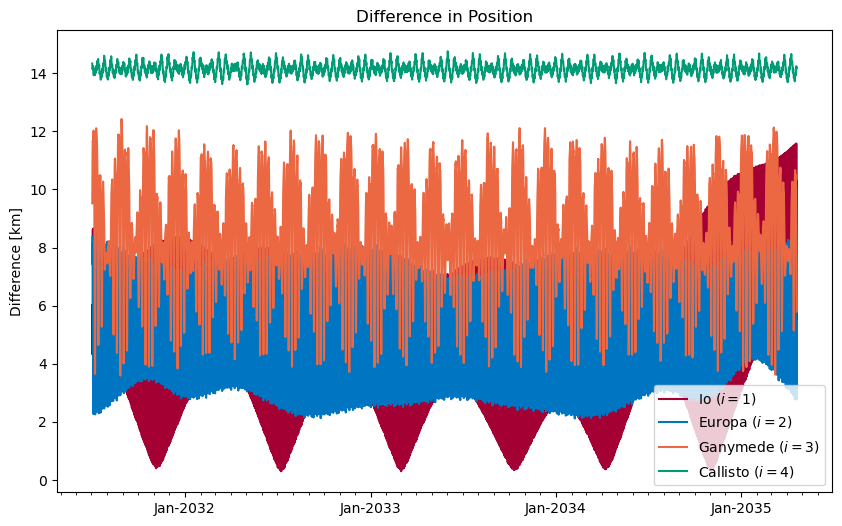

In [13]:
### LOAD DATA ###
simulator_object = estimation_output.simulation_results_per_iteration[-1]
state_history = simulator_object.dynamics_results.state_history
dependent_variable_history = simulator_object.dynamics_results.dependent_variable_history

### Ephemeris Kepler elements ####
# Initialize containers
ephemeris_state_history = dict()
ephemeris_keplerian_states = dict()
jupiter_gravitational_parameter = bodies.get('Jupiter').gravitational_parameter
# Loop over the propagated states and use the IMCEE ephemeris as benchmark solution
for epoch in state_history.keys():
    ephemeris_state = list()
    keplerian_state = list()
    for moon in bodies_to_propagate:
        ephemeris_state_temp = spice.get_body_cartesian_state_at_epoch(
            target_body_name=moon,
            observer_body_name='Jupiter',
            reference_frame_name='ECLIPJ2000',
            aberration_corrections='none',
            ephemeris_time=epoch)
        ephemeris_state.append(ephemeris_state_temp)
        keplerian_state.append(element_conversion.cartesian_to_keplerian(ephemeris_state_temp,
                                                                         jupiter_gravitational_parameter))

    ephemeris_state_history[epoch] = np.concatenate(np.array(ephemeris_state))
    ephemeris_keplerian_states[epoch] = np.concatenate(np.array(keplerian_state))

state_history_difference = np.vstack(list(state_history.values())) - np.vstack(list(ephemeris_state_history.values()))
position_difference = {'Io': state_history_difference[:, 0:3],
                       'Europa': state_history_difference[:, 6:9],
                       'Ganymede': state_history_difference[:, 12:15],
                       'Callisto': state_history_difference[:, 18:21]}

### PLOTTING ###
time2plt = list()
epochs_julian_seconds = np.vstack(list(state_history.keys()))
for epoch in epochs_julian_seconds:
    epoch_days = constants.JULIAN_DAY_ON_J2000 + epoch / constants.JULIAN_DAY
    time2plt.append(time_conversion.julian_day_to_calendar_date(epoch_days))

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

ax1.plot(time2plt, np.linalg.norm(position_difference['Io'], axis=1) * 1E-3,
         label=r'Io ($i=1$)', c='#A50034')
ax1.plot(time2plt, np.linalg.norm(position_difference['Europa'], axis=1) * 1E-3,
         label=r'Europa ($i=2$)', c='#0076C2')
ax1.plot(time2plt, np.linalg.norm(position_difference['Ganymede'], axis=1) * 1E-3,
         label=r'Ganymede ($i=3$)', c='#EC6842')
ax1.plot(time2plt, np.linalg.norm(position_difference['Callisto'], axis=1) * 1E-3,
         label=r'Callisto ($i=4$)', c='#009B77')
ax1.set_title(r'Difference in Position')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=1))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax1.set_ylabel(r'Difference [km]')
ax1.legend()

Overall, for the inner three moons trapped in resonance (for more details see below) the above results lie within the expected range of achievable accuracy given the rather rudimentary set-up of the environment and especially associated acceleration models. However, what is striking is that the performance of Callisto falls short compared to the other satellites. Thus, hypothetically, to enhance the estimated solution of the orbit of Callisto with respect to the underlying ephemeris, one could opt to estimate its gravity field alongside the initial state, which could lead to significantly improved results. However, this path is left as an adventure to be followed and explored by the reader.

In [14]:
def calculate_mean_longitude(kepler_elements: dict):
    # Calculate dictionary for moon-wise longitudes
    mean_longitude_dict = dict()
    # Loop over every moon of interest (Io, Europa, Ganymede)
    for moon in kepler_elements.keys():
        mean_anomaly_per_moon = list()
        kepler_elements_per_moon = kepler_elements[moon]
        # For every epoch get the mean anomaly of the moon
        for i in range(len(kepler_elements[moon])):
            mean_anomaly_per_moon.append(element_conversion.true_to_mean_anomaly(
                eccentricity=kepler_elements_per_moon[i, 1],
                true_anomaly=kepler_elements_per_moon[i, 5]))
        mean_anomaly_per_moon = np.array(mean_anomaly_per_moon)
        mean_anomaly_per_moon[mean_anomaly_per_moon < 0] = mean_anomaly_per_moon[mean_anomaly_per_moon < 0] \
                                                           + 2 * math.pi
        # Calculate the mean longitude as
        # (longitude of the ascending node) + (argument of the pericenter) + (mean anomaly)
        longitude_of_the_ascending_node = kepler_elements_per_moon[:, 4]
        argument_of_the_pericenter = kepler_elements_per_moon[:, 3]

        mean_longitude_per_moon = longitude_of_the_ascending_node + argument_of_the_pericenter + mean_anomaly_per_moon
        # Include epoch-wise mean longitude in dictionary
        mean_longitude_per_moon = np.mod(mean_longitude_per_moon, 2*math.pi)
        mean_longitude_dict[moon] = mean_longitude_per_moon

    return mean_longitude_dict

/tmp/ipykernel_627609/1296549662.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time2plt.append(time_conversion.julian_day_to_calendar_date(epoch_days))


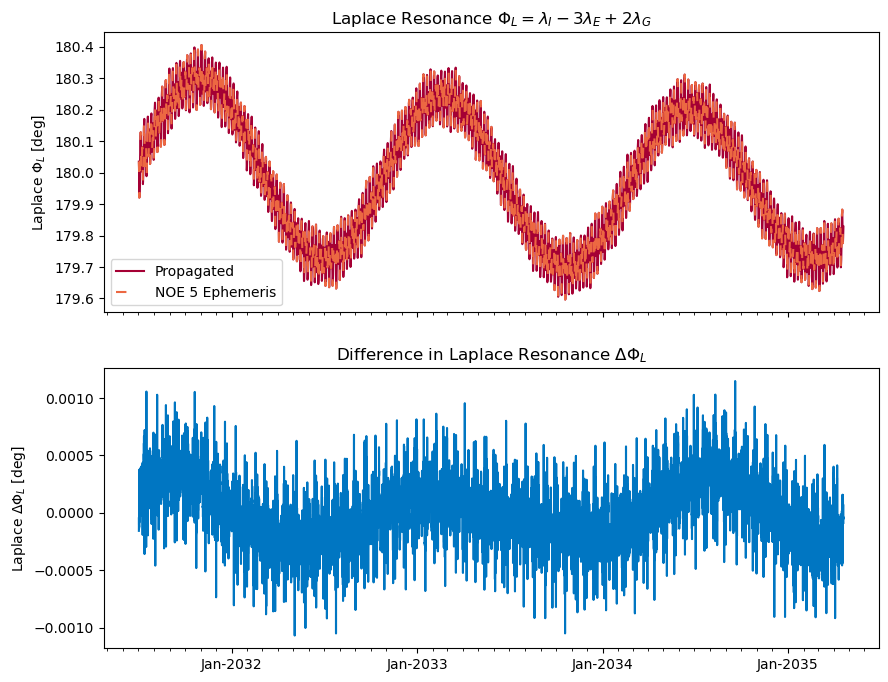

In [ ]:
### LAPLACE STABILITY ###
ephemeris_kepler_elements = np.vstack(list(ephemeris_keplerian_states.values()))
propagation_kepler_elements = np.vstack(list(dependent_variable_history.values()))

ephemeris_kepler_elements_dict = {'Io': ephemeris_kepler_elements[:, 0:6],
                                  'Europa': ephemeris_kepler_elements[:, 6:12],
                                  'Ganymede': ephemeris_kepler_elements[:, 12:18],
                                  'Callisto': ephemeris_kepler_elements[:, 18:24]}

propagated_kepler_elements_dict = {'Io': propagation_kepler_elements[:, 0:6],
                                   'Europa': propagation_kepler_elements[:, 6:12],
                                   'Ganymede': propagation_kepler_elements[:, 12:18],
                                   'Callisto': propagation_kepler_elements[:, 18:24]}

# Calculate propagated Laplace stability

mean_longitude_dict_prop = calculate_mean_longitude(propagated_kepler_elements_dict)

laplace_stability_prop = mean_longitude_dict_prop['Io'] \
                         - 3 * mean_longitude_dict_prop['Europa'] \
                         + 2 * mean_longitude_dict_prop['Ganymede']
laplace_stability_prop = np.mod(laplace_stability_prop, 2 * math.pi)

# Calculate ephemeris Laplace stability

mean_longitude_dict_ephem = calculate_mean_longitude(ephemeris_kepler_elements_dict)

laplace_stability_ephem = mean_longitude_dict_ephem['Io'] \
                         - 3 * mean_longitude_dict_ephem['Europa'] \
                         + 2 * mean_longitude_dict_ephem['Ganymede']
laplace_stability_ephem = np.mod(laplace_stability_ephem, 2 * math.pi)

### PLOTTING ###
time2plt = list()
epochs_julian_seconds = np.vstack(list(state_history.keys()))
for epoch in epochs_julian_seconds:
    epoch_days = constants.JULIAN_DAY_ON_J2000 + epoch / constants.JULIAN_DAY
    time2plt.append(time_conversion.julian_day_to_calendar_date(epoch_days))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
 
ax1.plot(time2plt, laplace_stability_prop * 180 / math.pi, label='Propagated', c='#A50034')
ax1.plot(time2plt, laplace_stability_ephem * 180 / math.pi, label='NOE 5 Ephemeris', c='#EC6842',
         linestyle=(0, (5, 10)))
ax1.set_title(r'Laplace Resonance $\Phi_L=\lambda_I-3 \lambda_E+2 \lambda_G$')
ax1.set_ylabel(r'Laplace $\Phi_L$ [deg]')
ax1.legend()

ax2.plot(time2plt, (laplace_stability_prop - laplace_stability_ephem) * 180 / math.pi, c='#0076C2')
ax2.set_title(r'Difference in Laplace Resonance $\Delta\Phi_L$')
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=1))
ax2.xaxis.set_minor_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax2.set_ylabel(r'Laplace $\Delta\Phi_L$ [deg]')